In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from torch.distributions import Categorical
from IPython import display as ipythondisplay
import imageio

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start()

### Environment

In [ ]:
env = gym.make('CartPole-v1').unwrapped

print(env.action_space.n)
print(env.observation_space)
print(env.spec.reward_threshold)

2
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
475.0


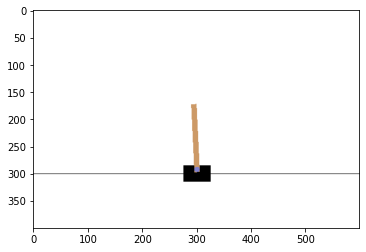

In [ ]:
env.reset()
screen = env.render(mode = 'rgb_array')
plt.imshow(screen)

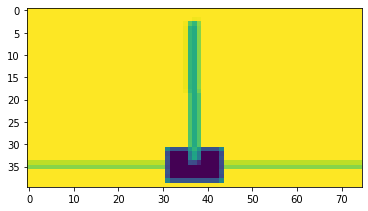

torch.Size([1, 40, 75])


In [ ]:
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize = T.Compose([T.ToPILImage(), T.Grayscale(), T.Resize(40, interpolation = Image.BICUBIC), T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen(env):
    screen = env.render(mode = 'rgb_array').transpose((2, 0, 1))
    _, height, width = screen.shape
    screen = screen[:, int(height*0.4):int(height * 0.8)]
    view_width = int(width * 0.5)
    cart_location = get_cart_location(width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
        
    screen = screen[:, :, slice_range]
    screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen(env).cpu().squeeze(0).numpy(), interpolation = 'none')
plt.show()

print(get_screen(env).size())

### Actor and Critic Networks

In [ ]:
class Net(nn.Module):
    def __init__(self, h, w, outputs):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size = 3, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 5, stride = 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 5, stride = 2)
        self.bn4 = nn.BatchNorm2d(64)

        conv2d_size_out = lambda size, kernel_size = 3, pad = 0, stride = 2 : (size + (2 * pad) - kernel_size) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(w, stride = 1), stride = 1), kernel_size = 5), kernel_size = 5)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(conv2d_size_out(h, stride = 1), stride = 1), kernel_size = 5), kernel_size = 5)
        flatten_input_size = convw * convh * 64
        print(flatten_input_size)
        self.fc1 = nn.Linear(flatten_input_size, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return F.softmax(x, -1)
  

### **TD Actor Critic Agent**

In [ ]:
class Agent:
    def __init__(self, env, lr = 0.0001, gamma = 0.999):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.gamma = gamma

        _, h, w = get_screen(env).size()
        self.actor = Net(h, w, self.action_space.n).to(device)
        self.critic = Net(h, w, 1).to(device)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr = lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr = lr)

        self.critic_criterion = nn.SmoothL1Loss()

    # ref: https://pytorch.org/docs/stable/distributions.html
    def step(self, state):
        probs = self.actor(state)
        state_val = self.critic(state)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action, log_prob, state_val

    def calculate_returns(self, rewards):
        returns = []
        curr = 0
        for r in reversed(rewards):
            curr = r + self.gamma * curr
            returns.append(curr)
        return torch.tensor(returns[::-1])
    
    def update(self, values, log_probs, rewards):
        returns = self.calculate_returns(rewards)
        returns = (returns - returns.mean()) / returns.std()
        actor_loss = []
        critic_loss = []

        for value, log_prob, R in zip(values, log_probs, returns):
            advantage = R - value.item()
            # Actor loss
            actor_loss.append(-1 * log_prob * advantage)
            # Crtic loss
            critic_loss.append(self.critic_criterion(torch.tensor([R], device = device).unsqueeze(1), value).unsqueeze(0))

        # Actor loss backprop
        self.actor_optimizer.zero_grad()
        actor_loss = torch.cat(actor_loss).mean()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Critic loss backprop
        self.critic_optimizer.zero_grad()
        critic_loss = torch.cat(critic_loss).mean()
        critic_loss.backward()
        self.critic_optimizer.step()

    def test(self):
        self.env.reset()
        images = []
        images.append(self.env.render(mode = 'rgb_array'))
        last_screen = get_screen(self.env)
        state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
        done = False
        while not done:
            with torch.no_grad():
                action = self.actor(state).max(1)[1].view(1, 1)
            _, reward, done, info = self.env.step(action.item())
            images.append(self.env.render(mode = 'rgb_array'))
            next_screen = get_screen(self.env)
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
            state = next_state
        
        imageio.mimsave('result_cartpole.gif', images)
        return images

    def saveWeights(self, path):
        torch.save(self.actor.state_dict(), path + '_actor')
        torch.save(self.critic.state_dict(), path + '_critic')

    def loadWeights(self, path):
        self.actor.load_state_dict(torch.load(path + '_actor'))
        self.critic.load_state_dict(torch.load(path + '_critic'))


### MDP

In [ ]:
agent = Agent(env)

total_rewards = []

episode = 0
while True:
    env.reset()
    done = False

    state_values = []
    log_probs = []
    rewards = []

    last_screen = get_screen(env)
    # stacking last 4 screens together as state
    state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
    curr_reward = 0
    
    while not done:
        action, log_prob, state_val = agent.step(state)
        state_values.append(state_val)
        log_probs.append(log_prob)
        _, reward, done, info = env.step(action.item())
        curr_reward += reward
        rewards.append(reward)
        next_screen = get_screen(env)

        if done:
            next_state = None
        else:
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)

        state = next_state
    
    agent.update(state_values, log_probs, rewards)

    total_rewards.append(curr_reward)
    avg_rewards = np.mean(total_rewards[-100:])
    if (episode + 1) % 50 == 0:
        print(f'{episode + 1} episode completed. Rewards: {avg_rewards}')
    episode += 1

    if avg_rewards >= env.spec.reward_threshold:
        break

print('Complete')

5760
5760
50 episode completed. Rewards: 50.0
100 episode completed. Rewards: 41.0
150 episode completed. Rewards: 69.0
200 episode completed. Rewards: 519.0
250 episode completed. Rewards: 198.0
300 episode completed. Rewards: 124.0
350 episode completed. Rewards: 113.0
400 episode completed. Rewards: 190.0
450 episode completed. Rewards: 257.0
500 episode completed. Rewards: 136.0
550 episode completed. Rewards: 107.0
600 episode completed. Rewards: 136.0
650 episode completed. Rewards: 157.0
700 episode completed. Rewards: 107.0
750 episode completed. Rewards: 98.0
800 episode completed. Rewards: 228.0
850 episode completed. Rewards: 18.0
900 episode completed. Rewards: 266.0
950 episode completed. Rewards: 212.0
1000 episode completed. Rewards: 200.0
1050 episode completed. Rewards: 192.0
1100 episode completed. Rewards: 337.0
1150 episode completed. Rewards: 195.0
1200 episode completed. Rewards: 181.0
1250 episode completed. Rewards: 165.0
1300 episode completed. Rewards: 617.0
1

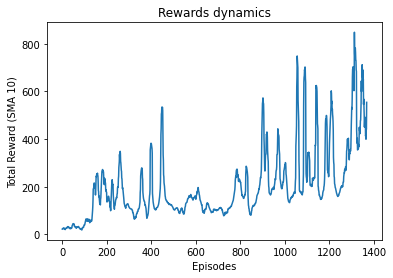

In [ ]:
# Plotting Total rewards received vs Episodes
step = 10
plt.title('Rewards dynamics')
plt.xlabel('Episodes')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])
plt.savefig('Rewards_dynamics.png')


In [ ]:
agent.saveWeights('AC_Cartpole')

In [ ]:
agent = Agent(env)
agent.loadWeights('AC_Cartpole')
imgs = agent.test()
len(imgs)

5760
5760


817